In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import time
from geopandas import GeoDataFrame
from utils.basefuncs import preProcessDataFrame
from utils.trajectoryClass import Trajectory
from utils.uuid import UUIDCollection
from utils.stopCollection import stopCollection,ExtractAndOrganizeData
from utils.gravityModel import POIgdf,activityMapper,gravityModel
from datetime import datetime,timedelta
import movingpandas as mpd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [2]:
warnings.filterwarnings("ignore")

In [3]:
path = r"D:\MSc\MSBD 5014\FindingPointsOfInterestFromGPS"
compiled_path = Path(path,"Configs.xlsx").resolve()
raw_path = Path(r"D:\MSc\MSBD 5014\Data","rawdata_202212.csv").resolve()

In [4]:
df_raw = pd.read_csv(raw_path)

In [5]:
preprocess = preProcessDataFrame(compiled_path,sheetname='preProcessDataFrame')
df = preprocess.processDF()

In [6]:
to_datetime = lambda x: datetime(year = x['ts_Year'],month = x['ts_Month'],day = x['ts_Day'],hour=x['ts_Hour'],minute = x['ts_Minute'],second = x['ts_Second'])

In [7]:
df['ts_Index'] = df.apply(to_datetime,axis = 1)

In [8]:
configs = {
    'col_missing_vals' : ['gpstime_Hour',
        'gpstime_Minute',
        'gpstime_Second',
        'gpstime_Day',
        'gpstime_Month',
        'gpstime_Year',
        'gpstime'],
    'fill_missing_vals' : [
        'ts_Hour',
       'ts_Minute', 
       'ts_Second', 
       'ts_Day', 
       'ts_Month', 
       'ts_Year', 
       'ts'],
    'UUID_Collection':{
        'unique_identifier_col' : 'uuid',
        'index_col' : 'ts_Index',
        'sort_values_col' : 'ts',
         'lat_col' : 'latitude',
        'long_col' : 'longitude',
        'required_cols' : ['gpsacc','lost'],
        'min_duration' : timedelta(seconds=30*60),
        'max_diameter' : 25,
        'min_points' : 200,
        'query_amount' : 450,
        'plot_map' : False
    },
    'STOP_Collection':{
        'min_distance' : 200,
        'stop_point_num' : 200
    },
    'POIgdf':{
        'id_col':'UUID',
        'poi_type_col_name' : 'POI Type',
        'activity_type_col_name':'Activity Types',
        'poi_point_col_name':'POI Point',
        'stop_point_lat': 'Stop Point Latitude',
        'stop_point_long':'Stop Point Longitude',
    },
    'activityMapper':{
        'file_path' : r"D:\MSc\MSBD 5014\FindingPointsOfInterestFromGPS\helper\POITypes.csv",
    }
} 

Fill in the missing values 

In [9]:
for col,ref in zip(configs['col_missing_vals'],configs['fill_missing_vals']):
    df.loc[df[col].isna(),col] =  df.loc[df[col].isna()][ref]
df.loc[df['gpsacc'].isna(),'gpsacc'] = df.loc[~df['gpsacc'].isna()]['gpsacc'].median()

In [10]:
len({k:grp.shape[0] for k,grp in df.groupby('uuid') if grp.shape[0]>200})

480

In [11]:
uuid_collection_obj = UUIDCollection(df,**configs['UUID_Collection'])
stop_collection_obj = stopCollection(uuid_collection_obj,**configs['STOP_Collection'])
queryObj = ExtractAndOrganizeData(stops_of_interest=stop_collection_obj.filtered_stops,radius = 200)
poigdf = queryObj.extractAndorganizeData()

Finished making Trajectory Objects
Starting to Get Stop Points for Every UUID
Finished Getting Stop Points for Every UUID
Starting to Filter points based on minimum distance between points
Finished obtaining points based on minimum distance


In [12]:
poigdf_obj = POIgdf(poigdf,**configs['POIgdf'])
activitymapper_obj = activityMapper(**configs['activityMapper'])
poigdf_obj = activitymapper_obj.reset_POI_types(poigdf_obj)
poigdf_obj = activitymapper_obj.add_activity_types(poigdf_obj)
gravitymodel = gravityModel(activitymapper_obj,poigdf_obj)
results = gravitymodel.calculate_probability()

In [13]:
uuid_collection_obj.complete_traj_stop_df

,ts_Index,gpsacc,lost,geometry,Stop Or Moving,uuid
0,2023-01-14 01:19:22,35.000014,0.0,POINT (114.26459 22.31852),M,112102
1,2023-01-14 01:19:24,35.000014,0.0,POINT (114.26459 22.31852),M,112102
2,2023-01-14 01:19:42,35.000000,0.0,POINT (114.26459 22.31850),M,112102
3,2023-01-14 01:19:54,35.000000,0.0,POINT (114.26461 22.31857),M,112102
4,2023-01-14 01:20:02,35.000000,0.0,POINT (114.26461 22.31857),M,112102
...,...,...,...,...,...,...
1918886,2023-04-05 14:36:12,31.569565,0.0,POINT (113.96917 22.40747),S,112874
1918887,2023-04-05 14:44:00,31.569565,0.0,POINT (113.96917 22.40747),S,112874
1918888,2023-04-05 14:56:02,31.569565,0.0,POINT (113.96917 22.40747),S,112874
1918889,2023-04-05 14:58:00,17.959828,0.0,POINT (113.96916 22.40771),M,112874


In [14]:
results

,Stop Point,UUID,Refuelling,Educational Supply,Daily Services,Religious,Leisure,Daily Shopping,Air Transport,Shopping,...,Other,Vehicle Purchase,Vehicle Wash,Financial,Maintenance Services,Gambling,Entertainment,Education,Shopping/Daily Shopping,Tourist
0,POINT (114.22452 22.28461),111069,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,45.433772,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,POINT (114.20942 22.33240),111156,0.0,0.0,0.000000,0.000000,0.0,7.435510,0.0,13.234882,...,0.000000,0.0,0.0,0.000000,0.0,0.0,4.338388,6.046086,0.0,0.000000
2,POINT (114.19950 22.34357),111222,0.0,0.0,0.000000,0.099888,0.0,1.842476,0.0,0.000000,...,0.203440,0.0,0.0,7.759953,0.0,0.0,0.000000,0.000000,0.0,0.000000
3,POINT (114.25087 22.30404),111541,0.0,0.0,0.000000,0.000000,0.0,21.114239,0.0,0.000000,...,16.641726,0.0,0.0,1.560685,0.0,0.0,0.000000,2.623151,0.0,0.000000
4,POINT (114.25288 22.30496),111541,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,27.994678,0.0,0.0,0.000000,0.465502,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,POINT (114.14949 22.49684),333484,0.0,0.0,0.000000,9.595510,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,28.786529
193,POINT (114.14255 22.49844),333484,0.0,0.0,0.000000,0.000000,0.0,0.183271,0.0,0.183271,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
194,POINT (114.14748 22.49904),333484,0.0,0.0,0.000000,0.000000,0.0,26.025171,0.0,52.050343,...,19.601541,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
195,POINT (114.14956 22.49982),333484,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000


In [15]:
rr

NameError: name 'rr' is not defined

In [16]:
# import pickle

# with open('poigdf_obj.pickle','wb') as handle:
#     pickle.dump(poigdf_obj,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open('activitymapper_obj.pickle','wb') as handle:
#     pickle.dump(activitymapper_obj,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open('gravitymodel.pickle','wb') as handle:
#     pickle.dump(gravitymodel,handle,protocol=pickle.HIGHEST_PROTOCOL)


In [23]:
def find_activity_for_each_point(data:pd.DataFrame):
    find_highest_activity = lambda x:sorted([(i,j) for i,j in x.to_dict().items()],key=lambda y:y[1],reverse=True)[0][0]
    attach_latitude = lambda x:x['Stop Point'].y
    attach_longitude = lambda x:x['Stop Point'].x
    activity_df = data[['Stop Point']]
    activity_probs = data[[i for i in data.columns if i not in ['Stop Point','UUID']]]
    activity_df['Activity at Point'] = activity_probs.apply(find_highest_activity,axis = 1)
    activity_df['Stop Point Latitude'] = activity_df.apply(attach_latitude,axis = 1)
    activity_df['Stop Point Longitude'] = activity_df.apply(attach_longitude,axis = 1)
    return activity_df

activity_df = find_activity_for_each_point(results)
activity_df = activity_df.merge(poigdf[['Stop Point','UUID','Time Spent at Stop Point','Stop Point Latitude','Stop Point Longitude']],how = 'left',on = ['Stop Point Latitude','Stop Point Longitude'],suffixes=('','_y'))
activity_df.drop(labels = activity_df.filter(regex=r"_y$").columns,axis = 1,inplace = True)
activity_df.drop_duplicates(subset=['Stop Point Latitude','Stop Point Longitude'],inplace = True)

In [24]:
activity_df['Time Spent at Stop Point (minutes)'] = activity_df['Time Spent at Stop Point']/60

In [25]:
def calculate_counts_for_each_activity(df):
    counts_df = pd.DataFrame(data = {'Activity Type':df['Activity at Point'].unique().tolist()})
    counts_df['Counts'] = np.nan
    for k,grp in df.groupby('Activity at Point'):
        counts_df.loc[counts_df['Activity Type'] == k,'Counts'] = grp.shape[0]
    return counts_df

counts_df = calculate_counts_for_each_activity(activity_df)

In [26]:
activity_df

,Stop Point,Activity at Point,Stop Point Latitude,Stop Point Longitude,UUID,Time Spent at Stop Point,Time Spent at Stop Point (minutes)
0,POINT (114.22452 22.28461),Other,22.284607,114.224521,111069,5914.0,98.566667
19,POINT (114.20942 22.33240),Health,22.332397,114.209423,111156,25254.0,420.900000
38,POINT (114.19950 22.34357),Food,22.343573,114.199496,111222,4287.0,71.450000
57,POINT (114.25087 22.30404),Food,22.304041,114.250868,111541,4230.0,70.500000
76,POINT (114.25288 22.30496),Food,22.304962,114.252879,111541,2130.0,35.500000
...,...,...,...,...,...,...,...
3605,POINT (114.14949 22.49684),Vehicle Repair,22.496841,114.149490,333484,6773.0,112.883333
3618,POINT (114.14255 22.49844),Food,22.498435,114.142553,333484,5427.0,90.450000
3637,POINT (114.14748 22.49904),Shopping,22.499039,114.147476,333484,7796.0,129.933333
3656,POINT (114.14956 22.49982),Daily Transport,22.499821,114.149563,333484,2601.0,43.350000


Boxplot for time spent at an activity

In [27]:
counts_df

,Activity Type,Counts
0,Other,7.0
1,Health,10.0
2,Food,107.0
3,Daily Shopping,6.0
4,Education,18.0
5,Daily Transport,23.0
6,Outdoor Leisure,4.0
7,Shopping,2.0
8,Financial,3.0
9,Religious,6.0


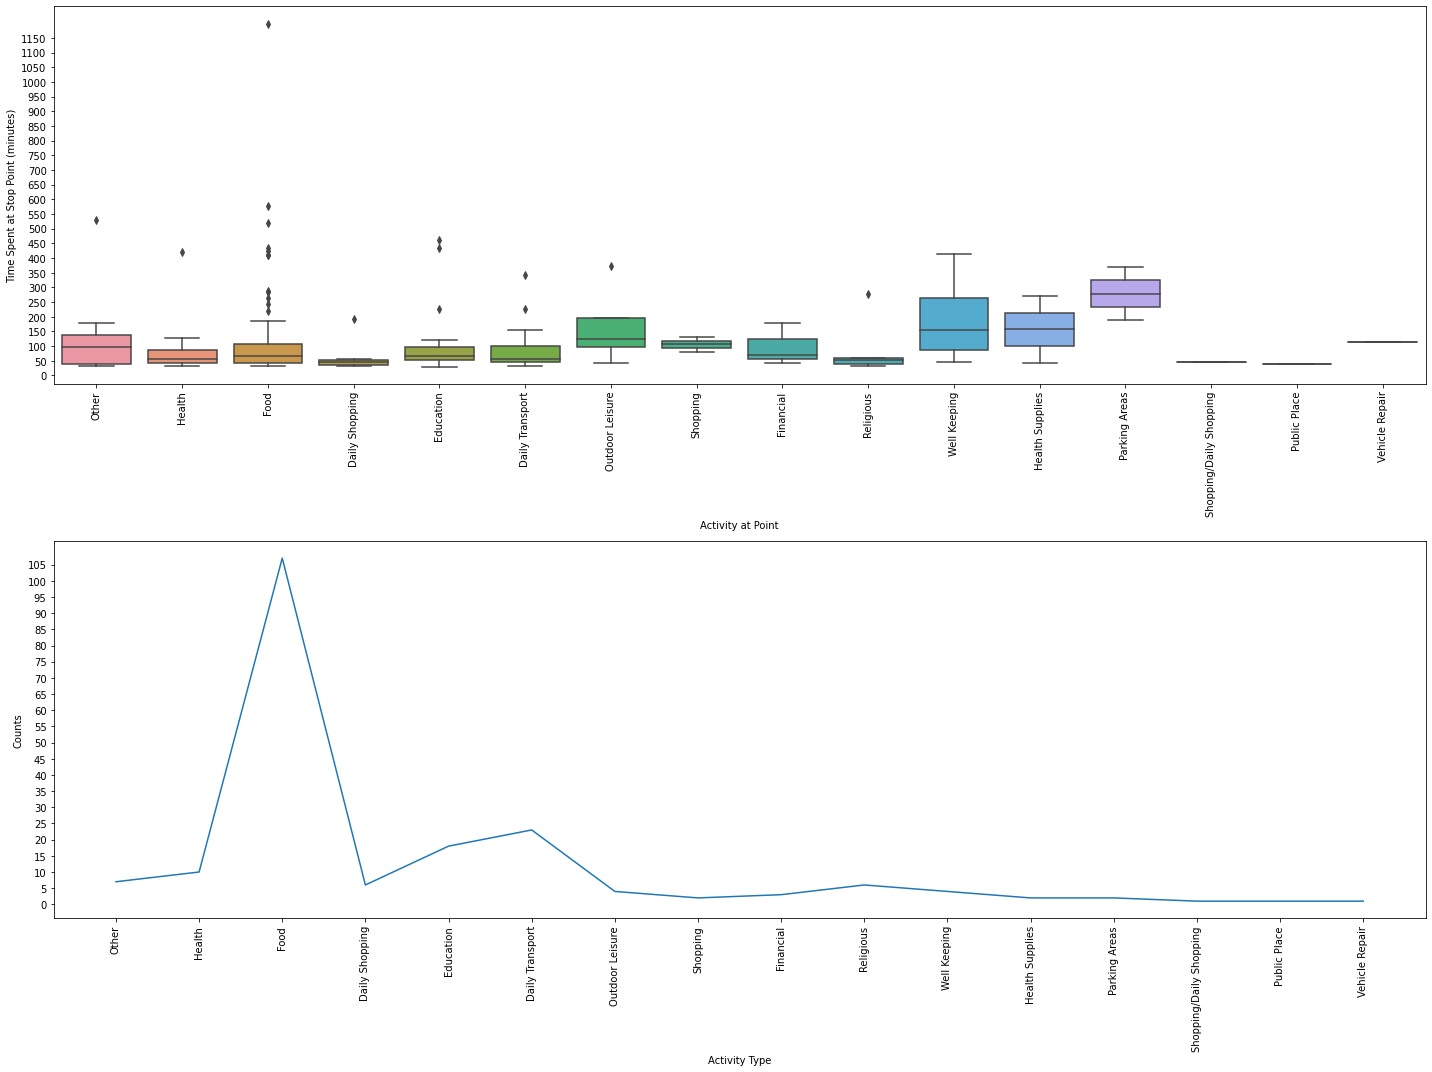

In [28]:
fig,ax = plt.subplots(2,1,figsize = (20,15))
sns.boxplot(data=activity_df,x = 'Activity at Point',y = 'Time Spent at Stop Point (minutes)',ax = ax[0])
sns.lineplot(data = counts_df,x = 'Activity Type',y = 'Counts',ax = ax[1])
ax[0].set_xticklabels(rotation = 90,labels=activity_df['Activity at Point'].unique().tolist())
ax[1].set_xticklabels(rotation = 90,labels=activity_df['Activity at Point'].unique().tolist())
ax[0].yaxis.set_ticks(np.arange(0,activity_df['Time Spent at Stop Point (minutes)'].max(),step = 50))
ax[1].yaxis.set_ticks(np.arange(0,counts_df['Counts'].max(),step = 5))
fig.tight_layout()

Also plot the varying probabilities

In [ ]:
# def make_boxplot(data):
#     fig,ax = plt.subplots(1,1,figsize = (20,10))
#     melt_df = pd.melt(results,id_vars=['Stop Point'],value_vars=[i for i in results.columns if i != 'Stop Point'],var_name = 'Activity Type',value_name='Activity Probability')
#     sns.boxplot(data = melt_df,x = 'Activity Type',y = 'Activity Probability',ax = ax)
#     ax.set_xticklabels(labels = melt_df['Activity Type'].unique(),rotation = 90)
# make_boxplot(results)
    

In [31]:
concat_df = uuid_collection_obj.complete_traj_stop_df.copy()
lat_val = lambda x : x.y
long_val = lambda x : x.x
concat_df["Latitude"] = concat_df['geometry'].apply(lat_val)
concat_df["Longitude"] = concat_df['geometry'].apply(long_val)

Concat_df contains all the details with GPS Accuracy, if a person was lost or not and if the point is a stop point or moving

In [32]:
concat_df

,ts_Index,gpsacc,lost,geometry,Stop Or Moving,uuid,Latitude,Longitude
0,2023-01-14 01:19:22,35.000014,0.0,POINT (114.26459 22.31852),M,112102,22.318523,114.264594
1,2023-01-14 01:19:24,35.000014,0.0,POINT (114.26459 22.31852),M,112102,22.318523,114.264594
2,2023-01-14 01:19:42,35.000000,0.0,POINT (114.26459 22.31850),M,112102,22.318500,114.264589
3,2023-01-14 01:19:54,35.000000,0.0,POINT (114.26461 22.31857),M,112102,22.318567,114.264606
4,2023-01-14 01:20:02,35.000000,0.0,POINT (114.26461 22.31857),M,112102,22.318567,114.264606
...,...,...,...,...,...,...,...,...
1918886,2023-04-05 14:36:12,31.569565,0.0,POINT (113.96917 22.40747),S,112874,22.407467,113.969173
1918887,2023-04-05 14:44:00,31.569565,0.0,POINT (113.96917 22.40747),S,112874,22.407467,113.969173
1918888,2023-04-05 14:56:02,31.569565,0.0,POINT (113.96917 22.40747),S,112874,22.407467,113.969173
1918889,2023-04-05 14:58:00,17.959828,0.0,POINT (113.96916 22.40771),M,112874,22.407708,113.969157


In [36]:
stop_point_data = stop_collection_obj.filtered_stops.copy()
stop_point_data['Latitude'] = stop_point_data['geometry'].apply(lat_val)
stop_point_data['Longitude'] = stop_point_data['geometry'].apply(long_val)

In [38]:
stop_point_data.reset_index(drop = True,inplace=True)
stop_point_data.head()

,geometry,start_time,end_time,traj_id,duration_s,uuid,Latitude,Longitude
0,POINT (114.26732 22.31576),2023-01-14 02:01:54,2023-01-14 04:48:03,2023-01-14,9969.0,112102,22.315761,114.267321
1,POINT (114.26365 22.31392),2023-01-14 10:03:35,2023-01-14 11:49:38,2023-01-14,6363.0,112102,22.313920,114.263654
2,POINT (114.20873 22.32080),2023-01-23 05:43:26,2023-01-23 06:31:58,2023-01-23,2912.0,112102,22.320798,114.208734
3,POINT (114.26999 22.31773),2023-01-28 16:49:41,2023-01-28 17:33:27,2023-01-28,2626.0,112102,22.317729,114.269987
4,POINT (114.21940 22.27954),2023-01-03 07:05:16,2023-01-03 13:14:47,2023-01-03,22171.0,332628,22.279538,114.219404


Including gps accuracy and if they were lost in the time span of the stop point

In [51]:
stop_point_data['Min gpsacc'] = np.nan
stop_point_data['Mean gpsacc'] = np.nan
stop_point_data['Median gpsacc'] = np.nan
stop_point_data['Max gpsacc'] = np.nan
stop_point_data['Number of Lost'] = np.nan
def calculate_gpsacc(gps_acc):
    min = gps_acc.min()
    max = gps_acc.max()
    median = gps_acc.median()
    mean = gps_acc.mean()
    return min,max,median,mean

def number_of_lost(lost):
    return lost.sum()

for i in range(stop_point_data.shape[0]):
    lat_val = stop_point_data.loc[i,"Latitude"]
    long_val = stop_point_data.loc[i,"Longitude"]
    start_time = stop_point_data.loc[i,"start_time"]
    end_time = stop_point_data.loc[i,'end_time']
    uuid = stop_point_data.loc[i,'uuid']
    
    temp_df = concat_df.loc[((concat_df['uuid'] == uuid) & (concat_df['ts_Index'] >= start_time) & (concat_df['ts_Index'] <= end_time))]
    min_gps,max_gps,median_gps,mean_gps = calculate_gpsacc(temp_df['gpsacc'])
    lost = number_of_lost(temp_df['lost'])
    stop_point_data.loc[i,['Min gpsacc','Max gpsacc','Median gpsacc','Mean gpsacc','Number of Lost']] = [min_gps,max_gps,median_gps,mean_gps,lost]

In [53]:
stop_point_data.head()

,geometry,start_time,end_time,traj_id,duration_s,uuid,Latitude,Longitude,Min gpsacc,Mean gpsacc,Median gpsacc,Max gpsacc,Number of Lost
0,POINT (114.26732 22.31576),2023-01-14 02:01:54,2023-01-14 04:48:03,2023-01-14,9969.0,112102,22.315761,114.267321,19.672864,21.512914,19.672864,25.193014,0.0
1,POINT (114.26365 22.31392),2023-01-14 10:03:35,2023-01-14 11:49:38,2023-01-14,6363.0,112102,22.313920,114.263654,35.000000,35.555556,35.000000,40.000000,0.0
2,POINT (114.20873 22.32080),2023-01-23 05:43:26,2023-01-23 06:31:58,2023-01-23,2912.0,112102,22.320798,114.208734,230.333333,230.333333,230.333333,230.333333,0.0
3,POINT (114.26999 22.31773),2023-01-28 16:49:41,2023-01-28 17:33:27,2023-01-28,2626.0,112102,22.317729,114.269987,3.962075,9.086320,10.480057,12.816829,0.0
4,POINT (114.21940 22.27954),2023-01-03 07:05:16,2023-01-03 13:14:47,2023-01-03,22171.0,332628,22.279538,114.219404,9.838000,16.176476,15.120000,180.095993,0.0


In [54]:
stop_point_data.loc[stop_point_data['duration_s'] > (550*60)]

,geometry,start_time,end_time,traj_id,duration_s,uuid,Latitude,Longitude,Min gpsacc,Mean gpsacc,Median gpsacc,Max gpsacc,Number of Lost
182,POINT (113.97558 22.38879),2023-02-13 01:22:13,2023-02-13 21:21:08,2023-02-13,71935.0,211922,22.388788,113.975581,0.00,22.371841,20.0,344.997986,0.0
187,POINT (114.13801 22.25922),2023-04-24 10:12:00,2023-04-24 19:49:16,2023-04-24,34636.0,333789,22.259221,114.138012,12.86,26.730448,24.9,191.888000,0.0
